### Mobile Games A/B Testing on Cookie's-Cats

In [1]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

C:\Users\Urmisha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Import the dataset
df=pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


*When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. As a sanity check, let's see if there are roughly the same number of players in each AB group.

In [3]:
# Counting the number of players in each AB group.
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

Text(0, 0.5, 'User Count')

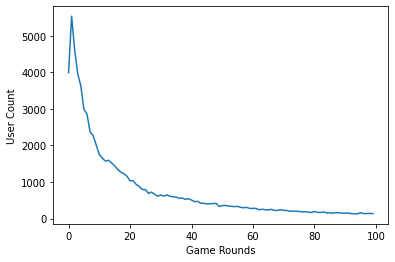

In [4]:
##Distribution of game rounds
#Analyze on how the gate placement affects player retention.


%matplotlib inline

# Counting the number of players for each number of game rounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid")
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

*In the plot above we can see that some players install the game but then never play it (0 game rounds), 
some players just play a couple of game rounds in their first week, and some get really hooked!

In [5]:
# What we want is for players to like the game and to get hooked. 
#A common metric in the video gaming industry for how fun and engaging a game is 1-day retention:
#The percentage of players that comes back and plays the game one day after they have installed it. 
#The higher 1-day retention is, the easier it is to retain players and build a large player base.

# The % of users that came back the day after they installed
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

*So, a little less than half of the players come back one day after installing the game.

In [6]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

*It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). 
It's a small change, but even small changes in retention can have a large impact.

<AxesSubplot:ylabel='Density'>

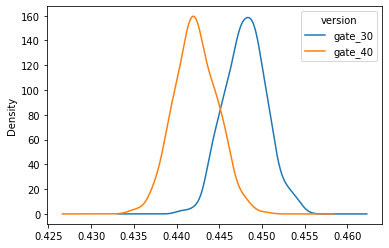

In [7]:
#Using bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. 
#The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

# Creating an list with bootstrapped means for each AB-group (To-resample with replacement)
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

* This evident from the difference.

Text(0.5, 0, '% difference in means')

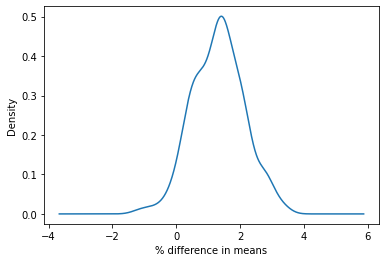

In [8]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

*From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. 

In [9]:
# Calculating the probability that 1-day retention 
# is greater when the gate is at level 30.
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.1%}'.format(prob)

'95.6%'

*The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30.

However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. 
That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.  

In [10]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

*Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

'100.0%'

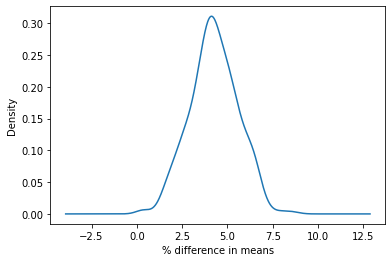

In [11]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
'{:.1%}'.format(prob)

### Conclusion:

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. Retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.

By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.